In [1]:
from torchinfo import summary
# from going_modular.going_modular import data_setup, engine # turn notebook to py scripts
# from util_plots import *
from util_plots2 import *
from util_dataload import *
from util_train import *

import torch
import torchvision
from torch import nn
from torchvision import transforms, datasets

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import time
import random
from tqdm.auto import tqdm
import os
import requests
import zipfile

from pathlib import Path
import pathlib

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
print("torch version: ", torch.__version__)



cuda
torch version:  1.13.1


In [2]:
# Setup path to data folder
data_path = Path("ham_data/")
image_path = data_path / "splitted_ham10000"

train_dir = image_path / "train"
test_dir = image_path / "test"

file_labels = []
for name in os.listdir(train_dir):
    file_labels.append(name)

print("Train directory: ",train_dir)
print("Test directory: ",test_dir)
print("Labels: ",file_labels)

Train directory:  ham_data\splitted_ham10000\train
Test directory:  ham_data\splitted_ham10000\test
Labels:  ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


Path: ham_data\splitted_ham10000\train\akiec  |  # of images:  261
Path: ham_data\splitted_ham10000\train\bcc  |  # of images:  411
Path: ham_data\splitted_ham10000\train\bkl  |  # of images:  879
Path: ham_data\splitted_ham10000\train\df  |  # of images:  92
Path: ham_data\splitted_ham10000\train\mel  |  # of images:  890
Path: ham_data\splitted_ham10000\train\nv  |  # of images:  5364
Path: ham_data\splitted_ham10000\train\vasc  |  # of images:  113
---
Path: ham_data\splitted_ham10000\test\akiec  |  # of images:  66
Path: ham_data\splitted_ham10000\test\bcc  |  # of images:  103
Path: ham_data\splitted_ham10000\test\bkl  |  # of images:  220
Path: ham_data\splitted_ham10000\test\df  |  # of images:  23
Path: ham_data\splitted_ham10000\test\mel  |  # of images:  223
Path: ham_data\splitted_ham10000\test\nv  |  # of images:  1341
Path: ham_data\splitted_ham10000\test\vasc  |  # of images:  29
---
Train size: 8010
Test size: 2005


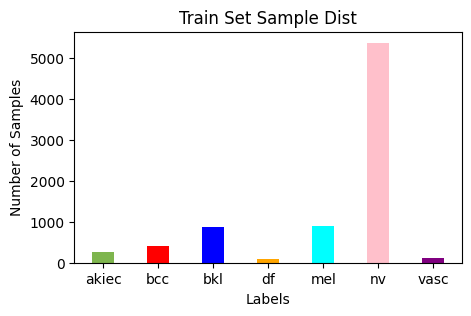

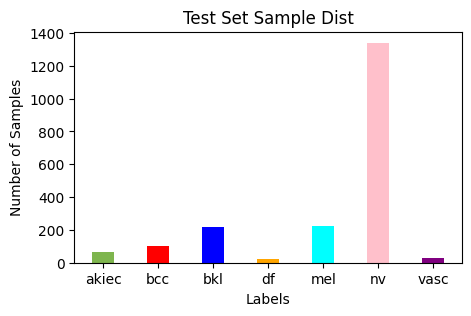

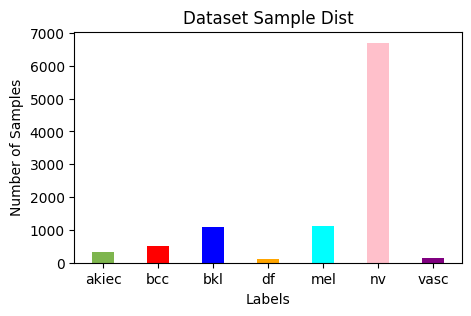

In [3]:
train_img_len = []
test_img_len = []

for file_name in [train_dir, test_dir]:
    for label_index in range(len(file_labels)):
        label_path = file_name/ file_labels[label_index]
        lst = os.listdir(label_path)
        number_of_imgs = len(lst)
        print("Path:", label_path, " |  # of images: ",number_of_imgs)

        if file_name == train_dir:
            train_img_len.append(number_of_imgs)
        if file_name == test_dir:
            test_img_len.append(number_of_imgs)
    print("---")


print("Train size:",sum(train_img_len))
print("Test size:",sum(test_img_len))

bar_colors = ['#7eb54e','red','blue','orange','cyan','pink','purple']

dataset_all_len = [sum(x) for x in zip(train_img_len, test_img_len)]

# print(train_img_len)
# print(test_img_len)
# print(dataset_all_len)

single_bar_plot_dataset_53(file_labels, train_img_len, "Train Set Sample Dist", "Labels", "Number of Samples", bar_color=bar_colors )
single_bar_plot_dataset_53(file_labels, test_img_len, "Test Set Sample Dist", "Labels", "Number of Samples", bar_color=bar_colors )
single_bar_plot_dataset_53(file_labels, dataset_all_len, "Dataset Sample Dist", "Labels", "Number of Samples", bar_color=bar_colors )


In [4]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT 
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [5]:
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(), # between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # standard deviation of [0.229, 0.224, 0.225] (across each colour channel)
])

In [17]:
!dir 

 Volume in drive C has no label.
 Volume Serial Number is ACA4-631C

 Directory of c:\Users\unatt\OneDrive\Masa�st�\ham10000_skin

22.02.2023  19:05    <DIR>          .
20.02.2023  11:14    <DIR>          ..
21.02.2023  12:47               195 data_util_split.py
21.02.2023  12:47    <DIR>          ham_data
22.01.2023  15:36           244.657 load_method_1.ipynb
03.02.2023  13:22           233.743 load_method_2.ipynb
22.02.2023  14:16             1.545 plot_params.py
22.02.2023  19:06           683.708 pre-train-ham.ipynb
21.02.2023  12:41            44.684 skin_lesion_ghub.ipynb
21.02.2023  19:40             1.179 skin_lesion_ghub.py
21.02.2023  20:59               759 util_dataload.py
22.02.2023  14:38             1.251 util_plots2.py
22.02.2023  19:06             4.028 util_train.py
22.02.2023  19:02    <DIR>          __pycache__
              10 File(s)      1.215.749 bytes
               4 Dir(s)  119.764.574.208 bytes free


In [6]:
from util_dataload import create_dataloader, get_class_names_dloader

BATCH_SIZE = 32

train_dataloader = create_dataloader(
                            file_dir=train_dir,
                            shuffle_opt= True,
                            transform=simple_transform, 
                            batch_size=BATCH_SIZE) 

test_dataloader = create_dataloader(
                            file_dir=test_dir,
                            shuffle_opt= False,
                            transform=simple_transform, 
                            batch_size=BATCH_SIZE) 

class_names = get_class_names_dloader(file_dir=train_dir, transform=simple_transform)

print("Batch size: ", BATCH_SIZE)
print("Number of train batches:",len(train_dataloader))
print("Number of test batches:",len(test_dataloader))

print("Number of classes: ",len(class_names))
print("Classes: ", class_names)

Batch size:  32
Number of train batches: 251
Number of test batches: 63
Number of classes:  7
Classes:  ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


# Create Pre-Trained Model

In [7]:
model_efficientNet0 = torchvision.models.efficientnet_b0(pretrained=True).to(device)

# Freeze all base layers in the "features" section of the model (the feature extractor)
for param in model_efficientNet0.features.parameters():
    param.requires_grad = False


c:\Users\unatt\anaconda3\envs\pytorch_env_v_1_13_1\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\unatt\anaconda3\envs\pytorch_env_v_1_13_1\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model_efficientNet0

In [8]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)

model_efficientNet0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.1, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape,
                    bias=True)).to(device)

In [ ]:
summary(model=model_efficientNet0, 
        input_size=(32, 3, 224, 224), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

# Train Model

In [10]:
from util_train import train

loss_fn = nn.CrossEntropyLoss() # multi-class classification
optimizer = torch.optim.Adam(model_efficientNet0.parameters(), lr=0.001)
no_of_epochs = 10

torch.manual_seed(42)
torch.cuda.manual_seed(42)

start_time_train = time.time()
model_0_results = train(model=model_efficientNet0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=no_of_epochs,
                       device=device,
                       log_txt_saver=True)

end_time_train = time.time()

print(f"Total training time: {end_time_train-start_time_train:.3f} (s).")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9173 | train_accuracy: 0.6990 | test_loss: 0.7969 | test_accuracy: 0.7423
Epoch: 2 | train_loss: 0.7338 | train_accuracy: 0.7448 | test_loss: 0.7104 | test_accuracy: 0.7488
Epoch: 3 | train_loss: 0.6820 | train_accuracy: 0.7587 | test_loss: 0.6884 | test_accuracy: 0.7588
Epoch: 4 | train_loss: 0.6481 | train_accuracy: 0.7705 | test_loss: 0.6541 | test_accuracy: 0.7764
Epoch: 5 | train_loss: 0.6254 | train_accuracy: 0.7770 | test_loss: 0.6597 | test_accuracy: 0.7645
Epoch: 6 | train_loss: 0.6087 | train_accuracy: 0.7827 | test_loss: 0.6385 | test_accuracy: 0.7737
Epoch: 7 | train_loss: 0.5951 | train_accuracy: 0.7859 | test_loss: 0.6321 | test_accuracy: 0.7717
Epoch: 8 | train_loss: 0.5874 | train_accuracy: 0.7858 | test_loss: 0.6332 | test_accuracy: 0.7720
Epoch: 9 | train_loss: 0.5727 | train_accuracy: 0.7949 | test_loss: 0.6339 | test_accuracy: 0.7724
Epoch: 10 | train_loss: 0.5654 | train_accuracy: 0.7943 | test_loss: 0.6201 | test_accuracy: 0.7841
Total tra

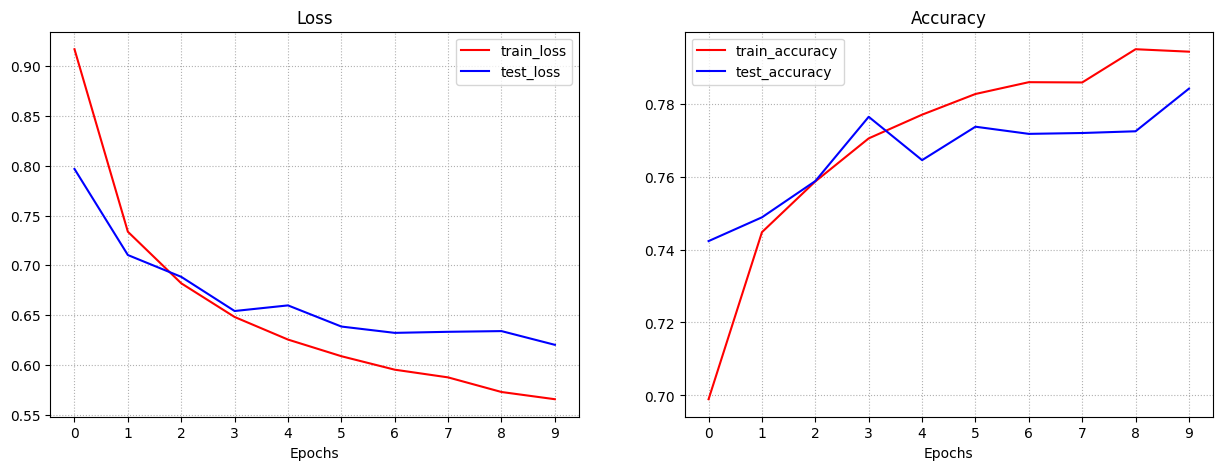

In [12]:
from util_plots2 import plot_loss_accuracy_grid2

def plot_loss_accuracy_grid2_v2(results):
    train_loss = results["train_loss"]
    test_loss = results["test_loss"]
    train_accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    x_ticks_range = 1

    # epochs = range(len(results["train_loss"]))
    epochs = np.arange(0, len(results["train_loss"]))

    plt.figure(figsize=(15, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.xticks(np.arange(min(epochs), max(epochs)+1, x_ticks_range))
    plt.plot(epochs, train_loss, label="train_loss", color = "red")
    plt.plot(epochs, test_loss, label="test_loss", color = "blue")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    plt.grid(True)
    plt.grid(True,linestyle=':')

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.xticks(np.arange(min(epochs), max(epochs)+1, x_ticks_range))
    plt.plot(epochs, train_accuracy, label="train_accuracy", color = "red")
    plt.plot(epochs, test_accuracy, label="test_accuracy", color = "blue")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()
    plt.grid(True,linestyle=':')


plot_loss_accuracy_grid2_v2(model_0_results)

# Test & Predictions

In [13]:
test_preds = []
model_efficientNet0.eval()

start_time_testset = time.time()

with torch.inference_mode():
  for X, y in tqdm(test_dataloader):
    X, y = X.to(device), y.to(device)
    
    test_logits = model_efficientNet0(X)
    pred_probs = torch.softmax(test_logits, dim=1)  # Convert the pred logits to pred probs
    pred_labels = torch.argmax(pred_probs, dim=1)  # Convert the pred probs into pred labels

    test_preds.append(pred_labels) 

end_time_testset = time.time()
print(f"Total testing time: {end_time_testset-start_time_testset:.3f} s.")

test_preds = torch.cat(test_preds).cpu()
test_truth = torch.cat([y for X, y in test_dataloader])

  0%|          | 0/63 [00:18<?, ?it/s]

Total testing time: 45.894 s.


Text(0.5, 1.0, 'Confusion Matrix\n\n(train acc: 0.794, train loss: 0.565)\n(test acc: 0.784, test loss: 0.62)\n(10 epochs)')

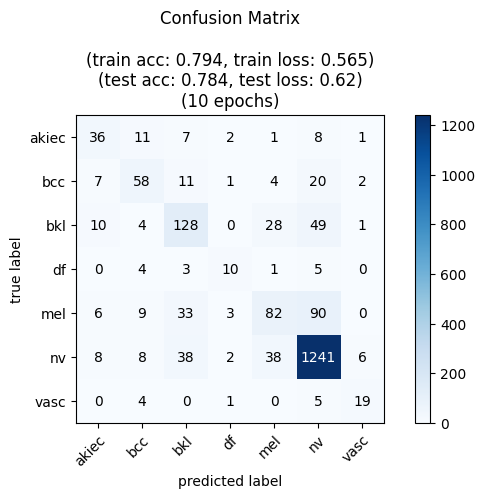

In [36]:
# !pip install -q torchmetrics -U mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

conf_matrix_multiclass = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
conf_matrix_tensor = conf_matrix_multiclass(preds=test_preds, target=test_truth)

fig, ax = plot_confusion_matrix(
    conf_mat=conf_matrix_tensor.numpy(), 
    class_names=class_names,
    figsize=(8, 4),
    colorbar=True,
    # cmap = 'magma_r'
)

last_train_acc = round(model_0_results['train_acc'][no_of_epochs-1],3)
last_train_loss = round(model_0_results['train_loss'][no_of_epochs-1],3)
last_test_acc = round(model_0_results['test_acc'][no_of_epochs-1],3)
last_test_loss = round(model_0_results['test_loss'][no_of_epochs-1],3)

ax.set_title(f"Confusion Matrix"
    +f"\n\n"+
    f"(train acc: {last_train_acc}, train loss: {last_train_loss})\n" +
    f"(test acc: {last_test_acc}, test loss: {last_test_loss})\n" +
    f"({no_of_epochs} epochs)"
    )

# Single Image Prediction

In [37]:
def pred_single_img(image_path, model, transform, class_names, device=device):
  image = Image.open(image_path)
  transformed_image = transform(image)

  model.eval()
  with torch.inference_mode():
    pred_logit = model(transformed_image.unsqueeze(0).to(device))
    pred_prob = torch.softmax(pred_logit, dim=1)
    pred_label = torch.argmax(pred_prob, dim=1)
    pred_class = class_names[pred_label.cpu()]
  
  pred_prob_squeezed = pred_prob.unsqueeze(0).max().cpu().item()
  # plot image and pred
  plt.imshow(image)
  plt.title(f"Pred: {pred_class} \n"+ 
            f"Probabilty: {pred_prob_squeezed:.3f} \n"+
            f"(h: {image.height}, w: {image.width})",
            fontsize=18)
            
  plt.axis(False); 

  print(image)
  print("img width:", image.width, 
          "\nimg height:", image.height)
  

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x24D419F2B90>
img width: 600 
img height: 450


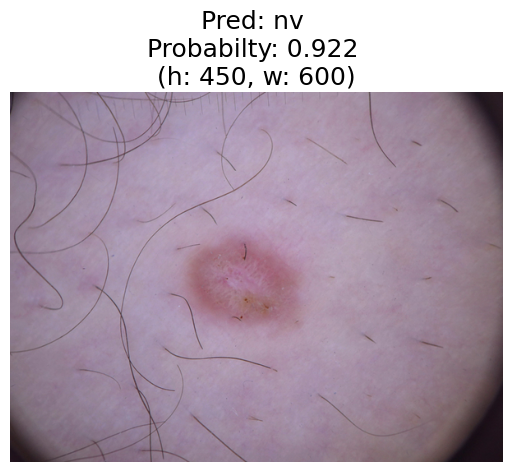

In [38]:
single_img_path_name = "ham_data/reorganized/df/ISIC_0027188.jpg"

pred_single_img(image_path=single_img_path_name,
              model=model_efficientNet0,
              transform=simple_transform,
              class_names=class_names)